In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import datetime as dt
import time 
import seaborn as sns 
from matplotlib.ticker import PercentFormatter
import calendar
import matplotlib.ticker as ticker
from PIL import * 
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
from matplotlib.patches import Polygon
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf 
from scipy.io import netcdf
from netCDF4 import Dataset
from wrf import (getvar, interplevel, to_np, latlon_coords)
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp2d
import matplotlib.cm as cm
import metpy.calc as mc
from metpy.units import units
import math as mt

In [2]:
parma = Dataset("maysak2015_rw.nc")

In [3]:
lons = parma.variables["XLONG"][:]
lon = lons[1, :,:]
lats = parma.variables["XLAT"][:]
lat = lats[1, :,:]
pb = parma.variables["PB"][:]
p = parma.variables["P"][:]
u = parma.variables["U"][:]
u = u[:,:,:, :254]
v = parma.variables["V"][:]
v = v[:,:,:194, :]
w = np.sqrt((u)**2 + (v)**2)*(1.94384)
q = parma.variables["QVAPOR"][:]
th = parma.variables["T"][:] + 300

pres = (p + pb)/100
temp = th*(pres/1000)**(0.2857)
temp1 = th*np.power((pres/1000), 0.2857)
es = 6.122*np.exp((17.67*(temp-273.15))/(temp-29.66))
ws = (0.622*es)/(pres-es)    # saturation mixing ratio
te = th * np.exp((2.54*(10**6)*ws)/(1004.67*temp))  # equivalent potential temperature
#te = te + 273.15

<ipython-input-3-987634b11b3f>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lons = parma.variables["XLONG"][:]
<ipython-input-3-987634b11b3f>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lats = parma.variables["XLAT"][:]
<ipython-input-3-987634b11b3f>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence 

In [4]:
lons.shape

(41, 194, 254)

In [5]:
date_ind = np.arange(0,41,1)
w_max = []
for i in date_ind: 
    wind = w[i, :, :, :]
    w_m = np.max(wind)
    w_max.append(w_m)
    
print(w_max)

[94.88224, 94.75454, 101.09843, 120.27948, 123.87343, 129.47417, 135.44908, 134.73106, 132.39246, 131.18271, 134.15991, 128.52654, 134.49077, 133.47644, 131.37517, 132.3803, 134.93689, 132.13739, 131.67387, 131.1766, 123.39924, 107.40082, 108.209854, 100.82215, 95.33704, 87.1049, 85.259636, 97.46408, 112.19166, 99.63508, 109.90594, 102.39098, 103.48479, 101.73397, 95.32538, 85.81917, 108.9037, 104.30624, 79.166885, 58.512115, 57.486332]


In [6]:
wind = pd.DataFrame({"MWS":w_max})
wind["diff_24h"] = -wind["MWS"].diff(-8)
wind["diff_18h"] = -wind["MWS"].diff(-6)
wind["diff_12h"] = -wind["MWS"].diff(-4)
wind["diff_6h"] = -wind["MWS"].diff(-2)
wind.to_excel("wind_maysak.xlsx")
wind

,MWS,diff_24h,diff_18h,diff_12h,diff_6h
0,94.882240,37.510216,40.566841,28.991188,6.216187
1,94.754539,36.428169,39.976524,34.719627,25.524940
2,101.098427,33.061485,31.294029,34.350655,22.775002
3,120.279480,8.247055,10.903229,14.451584,9.194687
4,123.873428,10.617340,10.286484,8.519028,11.575653
5,129.474167,4.002274,-0.947632,1.708542,5.256897
6,135.449081,-4.073914,-0.958313,-1.289169,-3.056625
7,134.731064,-2.350769,-1.254623,-6.204529,-3.548355
8,132.392456,2.544434,-1.017288,2.098312,1.767456
9,131.182709,0.954681,1.197586,2.293732,-2.656174


In [7]:
wind.MWS.max()

135.44908142089844

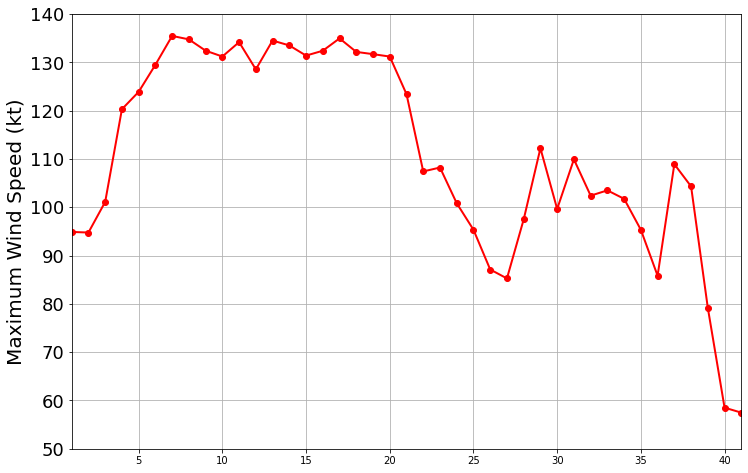

In [8]:
plt.figure(figsize = (12,8))
x = np.arange(1, 42, 1)
plt.plot(x, w_max, "ro-", linewidth = 2)

#labels = ["","04/02/15 09Z", "", "04/02/15 15Z", "","04/02/15 21Z", "","04/03/15 03Z","", "04/03/15 09Z","", "04/03/15 15Z", ""]
plt.xlim(1,41)
plt.ylim(50, 140)
#plt.xticks(x, labels, rotation=30, fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("Maximum Wind Speed (kt)", fontsize = 20)
plt.grid()

In [9]:
thres = wind[(wind["diff_6h"] <= 0) & (wind["diff_12h"] <= 0) & (wind["diff_18h"] <= 0) & (wind["diff_24h"] <= -20)]
thres

,MWS,diff_24h,diff_18h,diff_12h,diff_6h
13,133.476440,-26.075623,-2.299835,-1.339050,-1.096146
15,132.380295,-31.558144,-24.979477,-1.203690,-0.242905
16,134.936890,-39.599846,-26.727036,-11.537651,-3.263016
17,132.137390,-45.032494,-31.315239,-24.736572,-0.960785
18,131.673874,-46.414238,-36.336830,-23.464020,-8.274635
19,131.176605,-33.712524,-44.071709,-30.354454,-23.775787
30,109.905937,-30.739052,-1.002235,-14.580559,-6.421150


In [10]:
v.shape

(41, 32, 194, 254)

In [11]:
np.max(te)

474.9464

In [12]:
date = [10, 14, 18, 22, 26, 30, 6]
latx = [87, 96, 108,118, 126, 132, 79 ]
lonx = [191, 171,155,135,112, 88, 215 ]


In [13]:
lon1 = lons[date[0], latx[0], :]
lat1 = lons[date[0], :, lonx[0]]
print(lon1.shape)

pres1 = pres[date[0],:,latx[0],lonx[0] ]
#pres1 = pres1/100
print(pres1.shape)

lonss1, press1 = np.meshgrid(lon1, pres1)
latss1, presx1 = np.meshgrid(lat1, pres1)
w1 = w[date[0], 0:32, latx[0], : ]
U1 = u[date[0], :, latx[0], :]
V1 = v[date[0], :, latx[0], :]
te1 = te[date[0], :, latx[0], : ]
tex1 = te[date[0], :, :, lonx[0]]
print(w1.shape)
print(te1.shape)

(254,)
(32,)
(32, 254)
(32, 254)


In [14]:
pres1_800_700 = pres1[9:13]
pres1_300_200 = pres1[21:25]
pres1_300_200

masked_array(data=[303.8286437988281, 262.1564025878906,
                   222.6112060546875, 187.08929443359375],
             mask=[False, False, False, False],
       fill_value=1e+20,
            dtype=float32)

In [15]:
lon2 = lons[date[1], latx[1], :]
lat2 = lons[date[1], :, lonx[1]]
print(lon2.shape)

pres2 = pres[date[1],:,latx[1],lonx[1] ]
#pres2 = pres2/100
print(pres2.shape)

lonss2, press2 = np.meshgrid(lon2, pres2)
latss2, presx2 = np.meshgrid(lat2, pres2)
w2 = w[date[1], 0:32, latx[1], : ]
U2 = u[date[1], :, latx[1], :]
V2 = v[date[1], :, latx[1], :]
te2 = te[date[1],:, latx[1], : ]
tex2 = te[date[1], :, :, lonx[1]]
print(w2.shape)
print(te2.shape)

(254,)
(32,)
(32, 254)
(32, 254)


In [16]:
lon3 = lons[date[2], latx[2], :]
lat3 = lons[date[2], :, lonx[2]]
print(lon3.shape)

pres3 = pres[date[2],:,latx[2],lonx[2] ]
#pres3 = pres3/100
print(pres3.shape)

lonss3, press3 = np.meshgrid(lon3, pres3)
latss3, presx3 = np.meshgrid(lat3, pres3)
w3 = w[date[2], 0:32, latx[2], : ]
U3 = u[date[2], :, latx[2], :]
V3 = v[date[2], :, latx[2], :]
te3 = te[date[2],:, latx[2], : ]
tex3 = te[date[2], :, :, lonx[2]]
print(w3.shape)
print(te3.shape)

lon4 = lons[date[3], latx[3], :]
lat4 = lons[date[3], :, lonx[3]]
print(lon4.shape)

pres4 = pres[date[3],:,latx[3],lonx[3] ]
#pres4 = pres4/100
print(pres4.shape)

lonss4, press4 = np.meshgrid(lon4, pres4)
latss4, presx4 = np.meshgrid(lat4, pres4)
w4 = w[date[3], 0:32, latx[3], : ]
U4 = u[date[3], :, latx[3], :]
V4 = v[date[3], :, latx[3], :]
te4 = te[date[3],:, latx[3], : ]
tex4 = te[date[3], :, :, lonx[3]]
print(w4.shape)
print(te4.shape)

(254,)
(32,)
(32, 254)
(32, 254)
(254,)
(32,)
(32, 254)
(32, 254)


In [17]:
lon5 = lons[date[4], latx[4], :]
lat5 = lons[date[4], :, lonx[4]]
print(lon3.shape)

pres5 = pres[date[4],:,latx[4],lonx[4] ]
#pres3 = pres3/100
print(pres5.shape)

lonss5, press5 = np.meshgrid(lon5, pres5)
latss5, presx5 = np.meshgrid(lat5, pres5)
w5 = w[date[4], 0:32, latx[4], : ]
U5 = u[date[4], :, latx[4], :]
V5 = v[date[4], :, latx[4], :]
te5 = te[date[4],:, latx[4], : ]
tex5 = te[date[4], :, :, lonx[4]]
print(w5.shape)
print(te5.shape)

lon6 = lons[date[5], latx[5], :]
lat6 = lons[date[5], :, lonx[5]]
print(lon6.shape)

pres6 = pres[date[5],:,latx[5],lonx[5] ]
#pres4 = pres4/100
print(pres6.shape)

lonss6, press6 = np.meshgrid(lon6, pres6)
latss6, presx6 = np.meshgrid(lat6, pres6)
w6 = w[date[5], 0:32, latx[5], : ]
U6 = u[date[5], :, latx[5], :]
V6 = v[date[5], :, latx[5], :]
te6 = te[date[5],:, latx[5], : ]
tex6 = te[date[5], :, :, lonx[5]]
print(w6.shape)
print(te6.shape)

(254,)
(32,)
(32, 254)
(32, 254)
(254,)
(32,)
(32, 254)
(32, 254)


In [18]:
lon7 = lons[date[6], latx[6], :]
lat7 = lons[date[6], :, lonx[6]]
print(lon7.shape)

pres7 = pres[date[6],:,latx[6],lonx[6] ]
#pres1 = pres1/100
print(pres1.shape)

lonss7, press7 = np.meshgrid(lon7, pres7)
latss7, presx7 = np.meshgrid(lat7, pres7)
w7 = w[date[6], 0:32, latx[6], : ]
U7 = u[date[6], :, latx[6], :]
V7 = v[date[6], :, latx[6], :]
te7 = te[date[6], :, latx[6], : ]
tex7 = te[date[6], :, :, lonx[6]]
print(w1.shape)
print(te1.shape)

(254,)
(32,)
(32, 254)
(32, 254)


<ipython-input-19-15cc1aa885c8>:14: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(extend = "both")


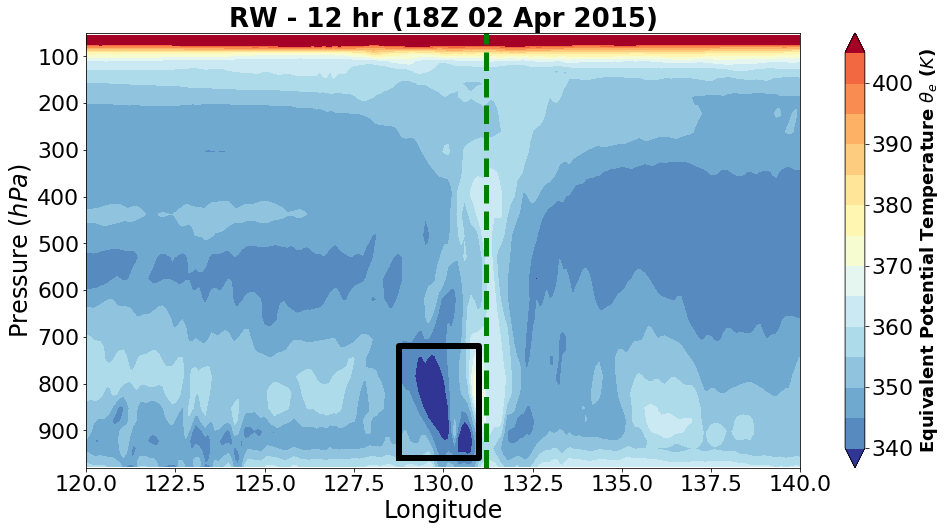

In [19]:
plt.figure(figsize = (16, 8))

s_x = [128.75, 128.75, 131, 131, 128.75]
s_y = [960, 720, 720, 960, 960]


plt.contourf(lonss4, press4, te4, np.arange(340, 410, 5), vmin=330, vmax =420,  cmap = "RdYlBu_r", extend = "both")
plt.plot(s_x, s_y, "k-", linewidth = 6)
plt.xlabel("Longitude", fontsize = 24)
plt.ylabel("Pressure ($hPa$)", fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
#plt.xlim(20,30)
cbar = plt.colorbar(extend = "both")
cbar.set_label("Equivalent Potential Temperature "  r"$\theta_{e}$ ($K$)", fontsize = 18, fontweight = "bold")
cbar.ax.tick_params(labelsize = 22)
#cbar.set_label("Z-wind component ($m/s^{2}$)", fontsize = 15)
plt.title("RW - 12 hr (18Z 02 Apr 2015)", fontsize = 26, fontweight = "bold")
#plt.axvline(x=136.2, color = "g", linestyle = "--")

ax = plt.gca()

ax.set_yticks(np.arange(0,1000,100))
ax.set_ylim([50,980])
ax.set_xlim([120,140])
ax.invert_yaxis()
ax.axvline(x=131.2, color = "g", linestyle = "--", linewidth = 5)

In [20]:
np.max(w1)

122.411835

In [21]:
c_lon = [136.5, 134.6, 133.2, 131.3, 129.2, 127.009, 138.679]
c_lon = np.deg2rad(c_lon)
c_lat = [10.9, 11.7, 12.8, 13.7, 14.4, 15, 10.2]
c_lat = np.deg2rad(c_lat)

In [22]:
lons1_m = lonss1[:, 164:191]
lons1_p = lonss1[:, 191:220]

w1= w1[:, 164:220]
U1= U1[:, 164:220]
V1= V1[:, 164:220]
te1 = te1[:, 164:220]
press1 = press1[:,164:220]

a1_m = (np.cos(c_lat[0])*np.cos(c_lat[0]))*(np.sin((np.deg2rad(lons1_m)-c_lon[0])/2)**2)
c1_m = 2*np.arctan2(np.sqrt(a1_m), np.sqrt(1-a1_m))
dist1_m = -6373*c1_m

a1_p = (np.cos(c_lat[0])*np.cos(c_lat[0]))*(np.sin((np.deg2rad(lons1_p)-c_lon[0])/2)**2)
c1_p = 2*np.arctan2(np.sqrt(a1_p), np.sqrt(1-a1_p))
dist1_p = 6373*c1_p

dist1 = np.concatenate((dist1_m, dist1_p), axis = 1)

In [23]:
lons2_m = lonss2[:, 143:170]
lons2_p = lonss2[:, 170:199]

w2= w2[:, 143:199]
U2= U2[:, 143:199]
V2= V2[:, 143:199]
te2 = te2[:,143:199]
press2 = press2[:,143:199]

a2_m = (np.cos(c_lat[1])*np.cos(c_lat[1]))*(np.sin((np.deg2rad(lons2_m)-c_lon[1])/2)**2)
c2_m = 2*np.arctan2(np.sqrt(a2_m), np.sqrt(1-a2_m))
dist2_m = -6373*c2_m

a2_p = (np.cos(c_lat[1])*np.cos(c_lat[1]))*(np.sin((np.deg2rad(lons2_p)-c_lon[1])/2)**2)
c2_p = 2*np.arctan2(np.sqrt(a2_p), np.sqrt(1-a2_p))
dist2_p = 6373*c2_p

dist2 = np.concatenate((dist2_m, dist2_p), axis = 1)

In [24]:
lons3_m = lonss3[:, 128:155]
lons3_p = lonss3[:, 155:184]

w3= w3[:,  128:184]
U3= U3[:,  128:184]
V3= V3[:,  128:184]
te3 = te3[:, 128:184]
press3 = press3[:, 128:184]

a3_m = (np.cos(c_lat[2])*np.cos(c_lat[2]))*(np.sin((np.deg2rad(lons3_m)-c_lon[2])/2)**2)
c3_m = 2*np.arctan2(np.sqrt(a3_m), np.sqrt(1-a3_m))
dist3_m = -6373*c3_m

a3_p = (np.cos(c_lat[2])*np.cos(c_lat[2]))*(np.sin((np.deg2rad(lons3_p)-c_lon[2])/2)**2)
c3_p = 2*np.arctan2(np.sqrt(a3_p), np.sqrt(1-a3_p))
dist3_p = 6373*c3_p

dist3 = np.concatenate((dist3_m, dist3_p), axis = 1)

In [25]:
lons4_m = lonss4[:, 108:135]
lons4_p = lonss4[:, 135:164]

w4= w4[:,  108:164]
U4= U4[:,  108:164]
V4= V4[:,  108:164]
te4 = te4[:, 108:164]
press4 = press4[:,108:164]

a4_m = (np.cos(c_lat[3])*np.cos(c_lat[3]))*(np.sin((np.deg2rad(lons4_m)-c_lon[3])/2)**2)
c4_m = 2*np.arctan2(np.sqrt(a4_m), np.sqrt(1-a4_m))
dist4_m = -6373*c4_m

a4_p = (np.cos(c_lat[3])*np.cos(c_lat[3]))*(np.sin((np.deg2rad(lons4_p)-c_lon[3])/2)**2)
c4_p = 2*np.arctan2(np.sqrt(a4_p), np.sqrt(1-a4_p))
dist4_p = 6373*c4_p

dist4 = np.concatenate((dist4_m, dist4_p), axis = 1)

In [26]:
lons5_m = lonss5[:, 85:112]
lons5_p = lonss5[:, 112:141]

w5= w5[:,  85:141]
V5= V5[:,  85:141]
U5= U5[:,  85:141]
te5 = te5[:, 85:141]
press5 = press5[:,85:141]

a5_m = (np.cos(c_lat[4])*np.cos(c_lat[4]))*(np.sin((np.deg2rad(lons5_m)-c_lon[4])/2)**2)
c5_m = 2*np.arctan2(np.sqrt(a5_m), np.sqrt(1-a5_m))
dist5_m = -6373*c5_m

a5_p = (np.cos(c_lat[4])*np.cos(c_lat[4]))*(np.sin((np.deg2rad(lons5_p)-c_lon[4])/2)**2)
c5_p = 2*np.arctan2(np.sqrt(a5_p), np.sqrt(1-a5_p))
dist5_p = 6373*c5_p

dist5 = np.concatenate((dist5_m, dist5_p), axis = 1)

In [27]:
lons6_m = lonss6[:, 61:88]
lons6_p = lonss6[:, 88:117]

w6= w6[:,61:117]
U6= U6[:,61:117]
V6= V6[:,61:117]
te6 = te6[:, 61:117]
press6 = press6[:,61:117]

a6_m = (np.cos(c_lat[5])*np.cos(c_lat[5]))*(np.sin((np.deg2rad(lons6_m)-c_lon[5])/2)**2)
c6_m = 2*np.arctan2(np.sqrt(a6_m), np.sqrt(1-a6_m))
dist6_m = -6373*c6_m

a6_p = (np.cos(c_lat[5])*np.cos(c_lat[5]))*(np.sin((np.deg2rad(lons6_p)-c_lon[5])/2)**2)
c6_p = 2*np.arctan2(np.sqrt(a6_p), np.sqrt(1-a6_p))
dist6_p = 6373*c6_p

dist6 = np.concatenate((dist6_m, dist6_p), axis = 1)

In [28]:
lons7_m = lonss7[:, 188:215]
lons7_p = lonss7[:, 215:244]

w7= w7[:,188:244]
U7= U7[:,188:244]
V7= V7[:,188:244]
te7 = te7[:,188:244]
press7 = press7[:,188:244]

a7_m = (np.cos(c_lat[6])*np.cos(c_lat[6]))*(np.sin((np.deg2rad(lons7_m)-c_lon[6])/2)**2)
c7_m = 2*np.arctan2(np.sqrt(a7_m), np.sqrt(1-a7_m))
dist7_m = -6373*c7_m

a7_p = (np.cos(c_lat[6])*np.cos(c_lat[6]))*(np.sin((np.deg2rad(lons7_p)-c_lon[6])/2)**2)
c7_p = 2*np.arctan2(np.sqrt(a7_p), np.sqrt(1-a7_p))
dist7_p = 6373*c7_p

dist7 = np.concatenate((dist7_m, dist7_p), axis = 1)

In [29]:
w5.shape

(32, 56)

In [31]:
np.min(te4)

334.749

In [34]:
np.min(w)

0.0018729394

In [35]:
np.max(w)

135.44908

In [36]:
np.max(w1)

122.411835

In [37]:
np.max(w2)

115.85924

In [38]:
np.max(w3)

110.16976

In [39]:
np.max(w4)

98.69225

In [40]:
np.max(w5)

71.08581

In [41]:
np.max(w6)

77.85741

In [42]:
wrf_lon = [136.5, 134.6, 133.2, 131.3, 129.2, 127.009]
wrf_lat = [10.9, 11.7, 12.8, 13.7, 14.4, 15]

jtwc_lon = [136.7, 134.7, 133.3, 131.9, 129.9, 127.7]
jtwc_lat = [11, 12, 12.8, 13.7, 14, 14.4]

Text(0.5, 1.0, 'Partial Track of TC Maysak (2015)')

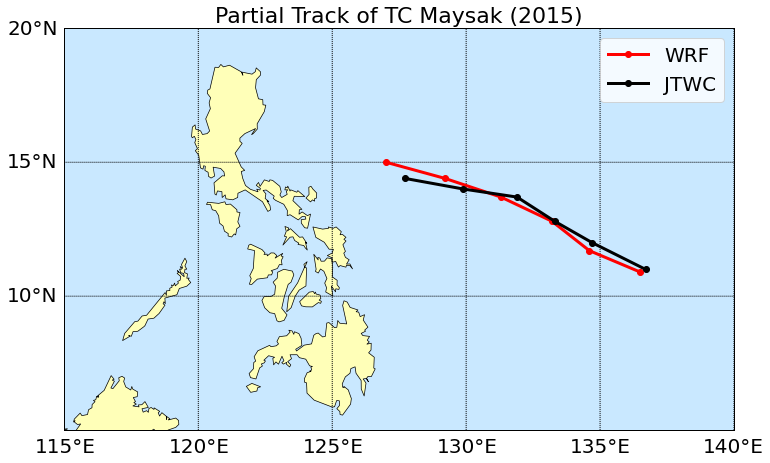

In [43]:
plt.figure(figsize = (12,8))
m = Basemap(projection = 'cyl', llcrnrlat=5,urcrnrlat=20, llcrnrlon=115,urcrnrlon=140,lat_ts = 20, resolution='l')
m.drawcoastlines(linewidth = 0.7)
m.drawmapboundary(fill_color = "#c9e8ff")
m.drawcountries(linewidth = 0.7)
#m.drawstates(linewidth = 0.5)
m.fillcontinents(color='#ffffb8')
m.drawparallels(np.arange(10,90,5),labels=[1,0,0,0], fontsize = 20)
m.drawmeridians(np.arange(-180,180,5),labels=[0,0,0,1], fontsize = 20)

#x,y = m(wr_lon, c_lat)
m.plot(wrf_lon, wrf_lat, "ro-", linewidth = 3, label = "WRF")
m.plot(jtwc_lon, jtwc_lat, "ko-", linewidth = 3, label="JTWC")
plt.legend(fontsize = 20, loc ="upper right")
plt.title("Partial Track of TC Maysak (2015)", fontsize =22)

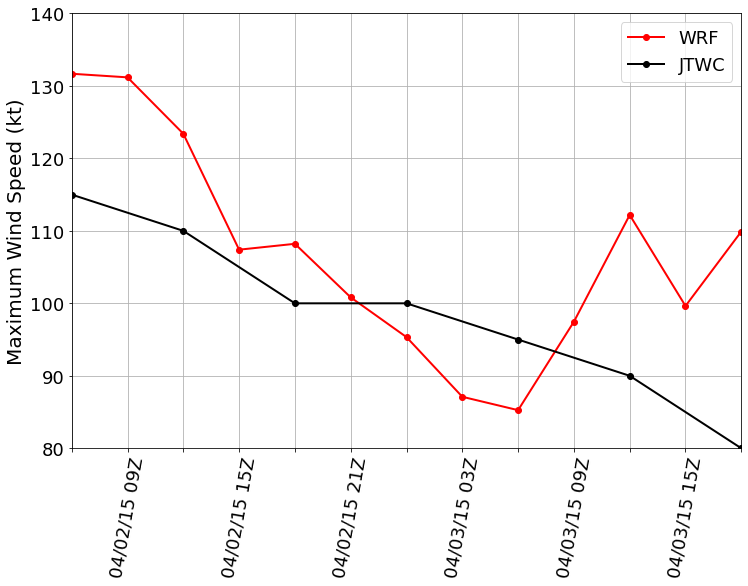

In [44]:
plt.figure(figsize = (12,8))
x = np.arange(1, 14, 1)
x1 = [1, 3, 5, 7, 9, 11, 13]
y1 = [115, 110, 100, 100, 95, 90, 80]
plt.plot(x, w_max[18:31], "ro-", linewidth = 2, label = "WRF")
plt.plot(x1, y1, "ko-", linewidth = 2, label = "JTWC")

labels = ["","04/02/15 09Z", "", "04/02/15 15Z", "","04/02/15 21Z", "","04/03/15 03Z","", "04/03/15 09Z","", "04/03/15 15Z", ""]
plt.xlim(1,13)
plt.ylim(80, 140)
plt.xticks(x, labels, rotation=80, fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("Maximum Wind Speed (kt)", fontsize = 20)
plt.legend(fontsize = 18)
plt.grid()

In [45]:
ww  = w_max[18:31]
ww = ww[::2]
len(ww)

7

In [46]:
import sklearn 
mse = sklearn.metrics.mean_squared_error(y1, ww)
rmse = mt.sqrt(mse)
print(rmse)

17.02272426034494


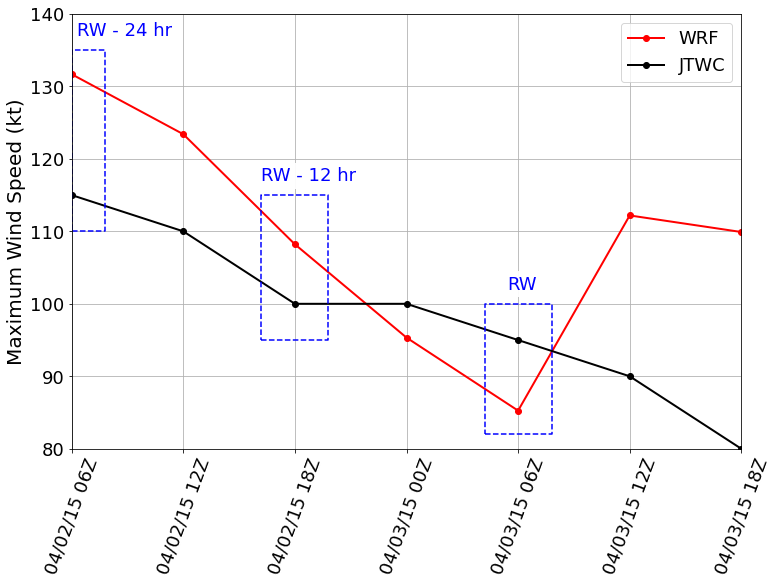

In [84]:
plt.figure(figsize = (12,8))
x = np.arange(1, 8, 1)
#x1 = [1, 3, 5, 7, 9, 11, 13]
y = [115, 110, 100, 100, 95, 90, 80]
plt.plot(x, ww, "ro-", linewidth = 2, label = "WRF")
plt.plot(x, y, "ko-", linewidth = 2, label = "JTWC")

x1 = [1, 1.3, 1.3, 1, 1]
y1 = [110, 110, 135, 135, 110]
plt.plot(x1,y1, "b--")

x2 = [2.7, 3.3, 3.3, 2.7, 2.7]
y2 = [95, 95, 115, 115, 95]
plt.plot(x2,y2, "b--")

x3 = [4.7, 5.3, 5.3, 4.7, 4.7]
y3 = [82, 82, 100, 100, 82]
plt.plot(x3,y3, "b--")

text1 = r"RW - 24 hr"
tx1= plt.text(1.05, 137, text1, fontsize = 18, zorder = 199, color = "b")
tx1.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "none"))

text2 = r"RW - 12 hr"
tx2= plt.text(2.7, 117, text2, fontsize = 18, zorder = 199, color = "b")
tx2.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "none"))

text3 = r"RW"
tx3= plt.text(4.9, 102, text3, fontsize = 18, zorder = 199, color = "b")
tx3.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "none"))

labels = ["04/02/15 06Z",  "04/02/15 12Z", "04/02/15 18Z", "04/03/15 00Z", "04/03/15 06Z", "04/03/15 12Z", "04/03/15 18Z"]
plt.xlim(1,6)
plt.ylim(80, 140)
plt.xticks(x, labels, rotation=70, fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("Maximum Wind Speed (kt)", fontsize = 20)
plt.legend(fontsize = 18)
plt.grid()

Text(0, 0.5, 'Maximum Wind Speed (kt)')

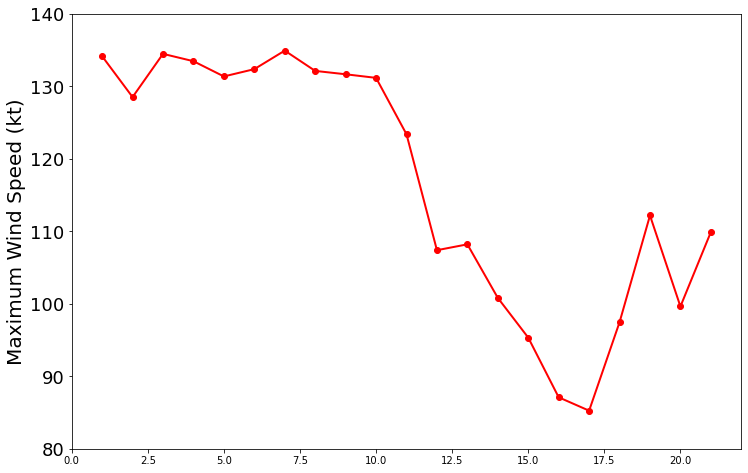

In [49]:
plt.figure(figsize = (12,8))
x = np.arange(1, 22, 1)
plt.plot(x, w_max[10:31], "ro-", linewidth = 2)

#labels = ["","04/02/15 09Z", "", "04/02/15 15Z", "","04/02/15 21Z", "","04/03/15 03Z","", "04/03/15 09Z","", "04/03/15 15Z", ""]
#plt.xlim(1,13)
plt.ylim(80, 140)
#plt.xticks(x, labels, rotation=30, fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("Maximum Wind Speed (kt)", fontsize = 20)

In [50]:
len(x)

21

In [51]:
len(w_max[10:31])

21

In [52]:
w_max[18]

131.67387

In [53]:
w_max[18:30]

[131.67387,
 131.1766,
 123.39924,
 107.40082,
 108.209854,
 100.82215,
 95.33704,
 87.1049,
 85.259636,
 97.46408,
 112.19166,
 99.63508]

In [54]:
press1[9:13, 1]

masked_array(data=[809.0321 , 774.77673, 737.4034 , 697.6791 ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [55]:
w1_l = V1[9:13,:]
w1_u = V1[21:25, :]
print(np.mean(w1_u))
print(np.mean(w1_l))
print(np.mean(w1_l) - np.mean(w1_u))
print(np.max(te1[0:22, :]))
print(np.min(te1[0:22, :]))

3.489616
2.1555128
-1.3341031
385.59363
341.20963


In [56]:
w2_l = V2[9:13, :]
w2_u = V2[21:25, :]
print(np.mean(w2_u))
print(np.mean(w2_l))
print(np.mean(w2_u) - np.mean(w2_l))
print(np.max(te2[0:22, :]))
print(np.min(te2[0:22, :]))

1.145459
1.6247786
-0.47931957
389.0176
340.66275


In [57]:
w3_l = V3[9:13, :]
w3_u = V3[21:25, :]
print(np.mean(w3_u))
print(np.mean(w3_l))
print(np.mean(w3_u) - np.mean(w3_l))
print(np.max(te3[0:22, :]))
print(np.min(te3[0:22, :]))

0.60828274
5.609927
-5.0016446
376.2493
340.42578


In [58]:
w4_l = V4[9:13, :]
w4_u = V4[21:25, :]
print(np.mean(w4_u))
print(np.mean(w4_l))
print(np.mean(w4_u) - np.mean(w4_l))
print(np.max(te4[0:22, :]))
print(np.min(te4[0:22, :]))

-0.34876838
3.760681
-4.1094494
375.04398
334.749


In [59]:
w5_l = V5[9:13, :]
w5_u = V5[21:25, :]
print(np.mean(w5_u))
print(np.mean(w5_l))
print(np.mean(w5_u) - np.mean(w5_l))
print(np.max(te5[0:22, :]))
print(np.min(te5[0:22, :]))

-4.1451464
4.3845196
-8.529666
367.03354
340.84103


In [60]:
w6_l = V6[9:13, :]
w6_u = V6[21:25, :]
print(np.mean(w6_u))
print(np.mean(w6_l))
print(np.mean(w6_u) - np.mean(w6_l))
print(np.max(te6[0:22, :]))
print(np.min(te6[0:22, :]))

-0.47366375
5.665944
-6.139608
370.89258
336.4011


In [61]:
w7_l = V7[9:13, :]
w7_u = V7[21:25, :]
print(np.mean(w7_u))
print(np.mean(w7_l))
print(np.mean(w7_l) - np.mean(w7_u))
print(np.max(te7[0:22, :]))

2.4346452
0.8648314
-1.5698137
381.86816


In [62]:
te7.shape

(32, 56)

<ipython-input-63-acfd19ae8af8>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(axes[0,0].get_xticklabels(), Fontsize = 25)
<ipython-input-63-acfd19ae8af8>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(axes[0,0].get_yticklabels(), Fontsize = 25)
<ipython-input-63-acfd19ae8af8>:42: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(axes[0,1].get_xticklabels(), Fontsize = 25)
<ipython-input-63-acfd19ae8af8>:43: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(axes[0,1].get_yticklabels(), Fontsize = 25)
<ipython-input-63-acfd19ae8af8>:72: MatplotlibDeprecationWarning: Case-insensitive properties were d

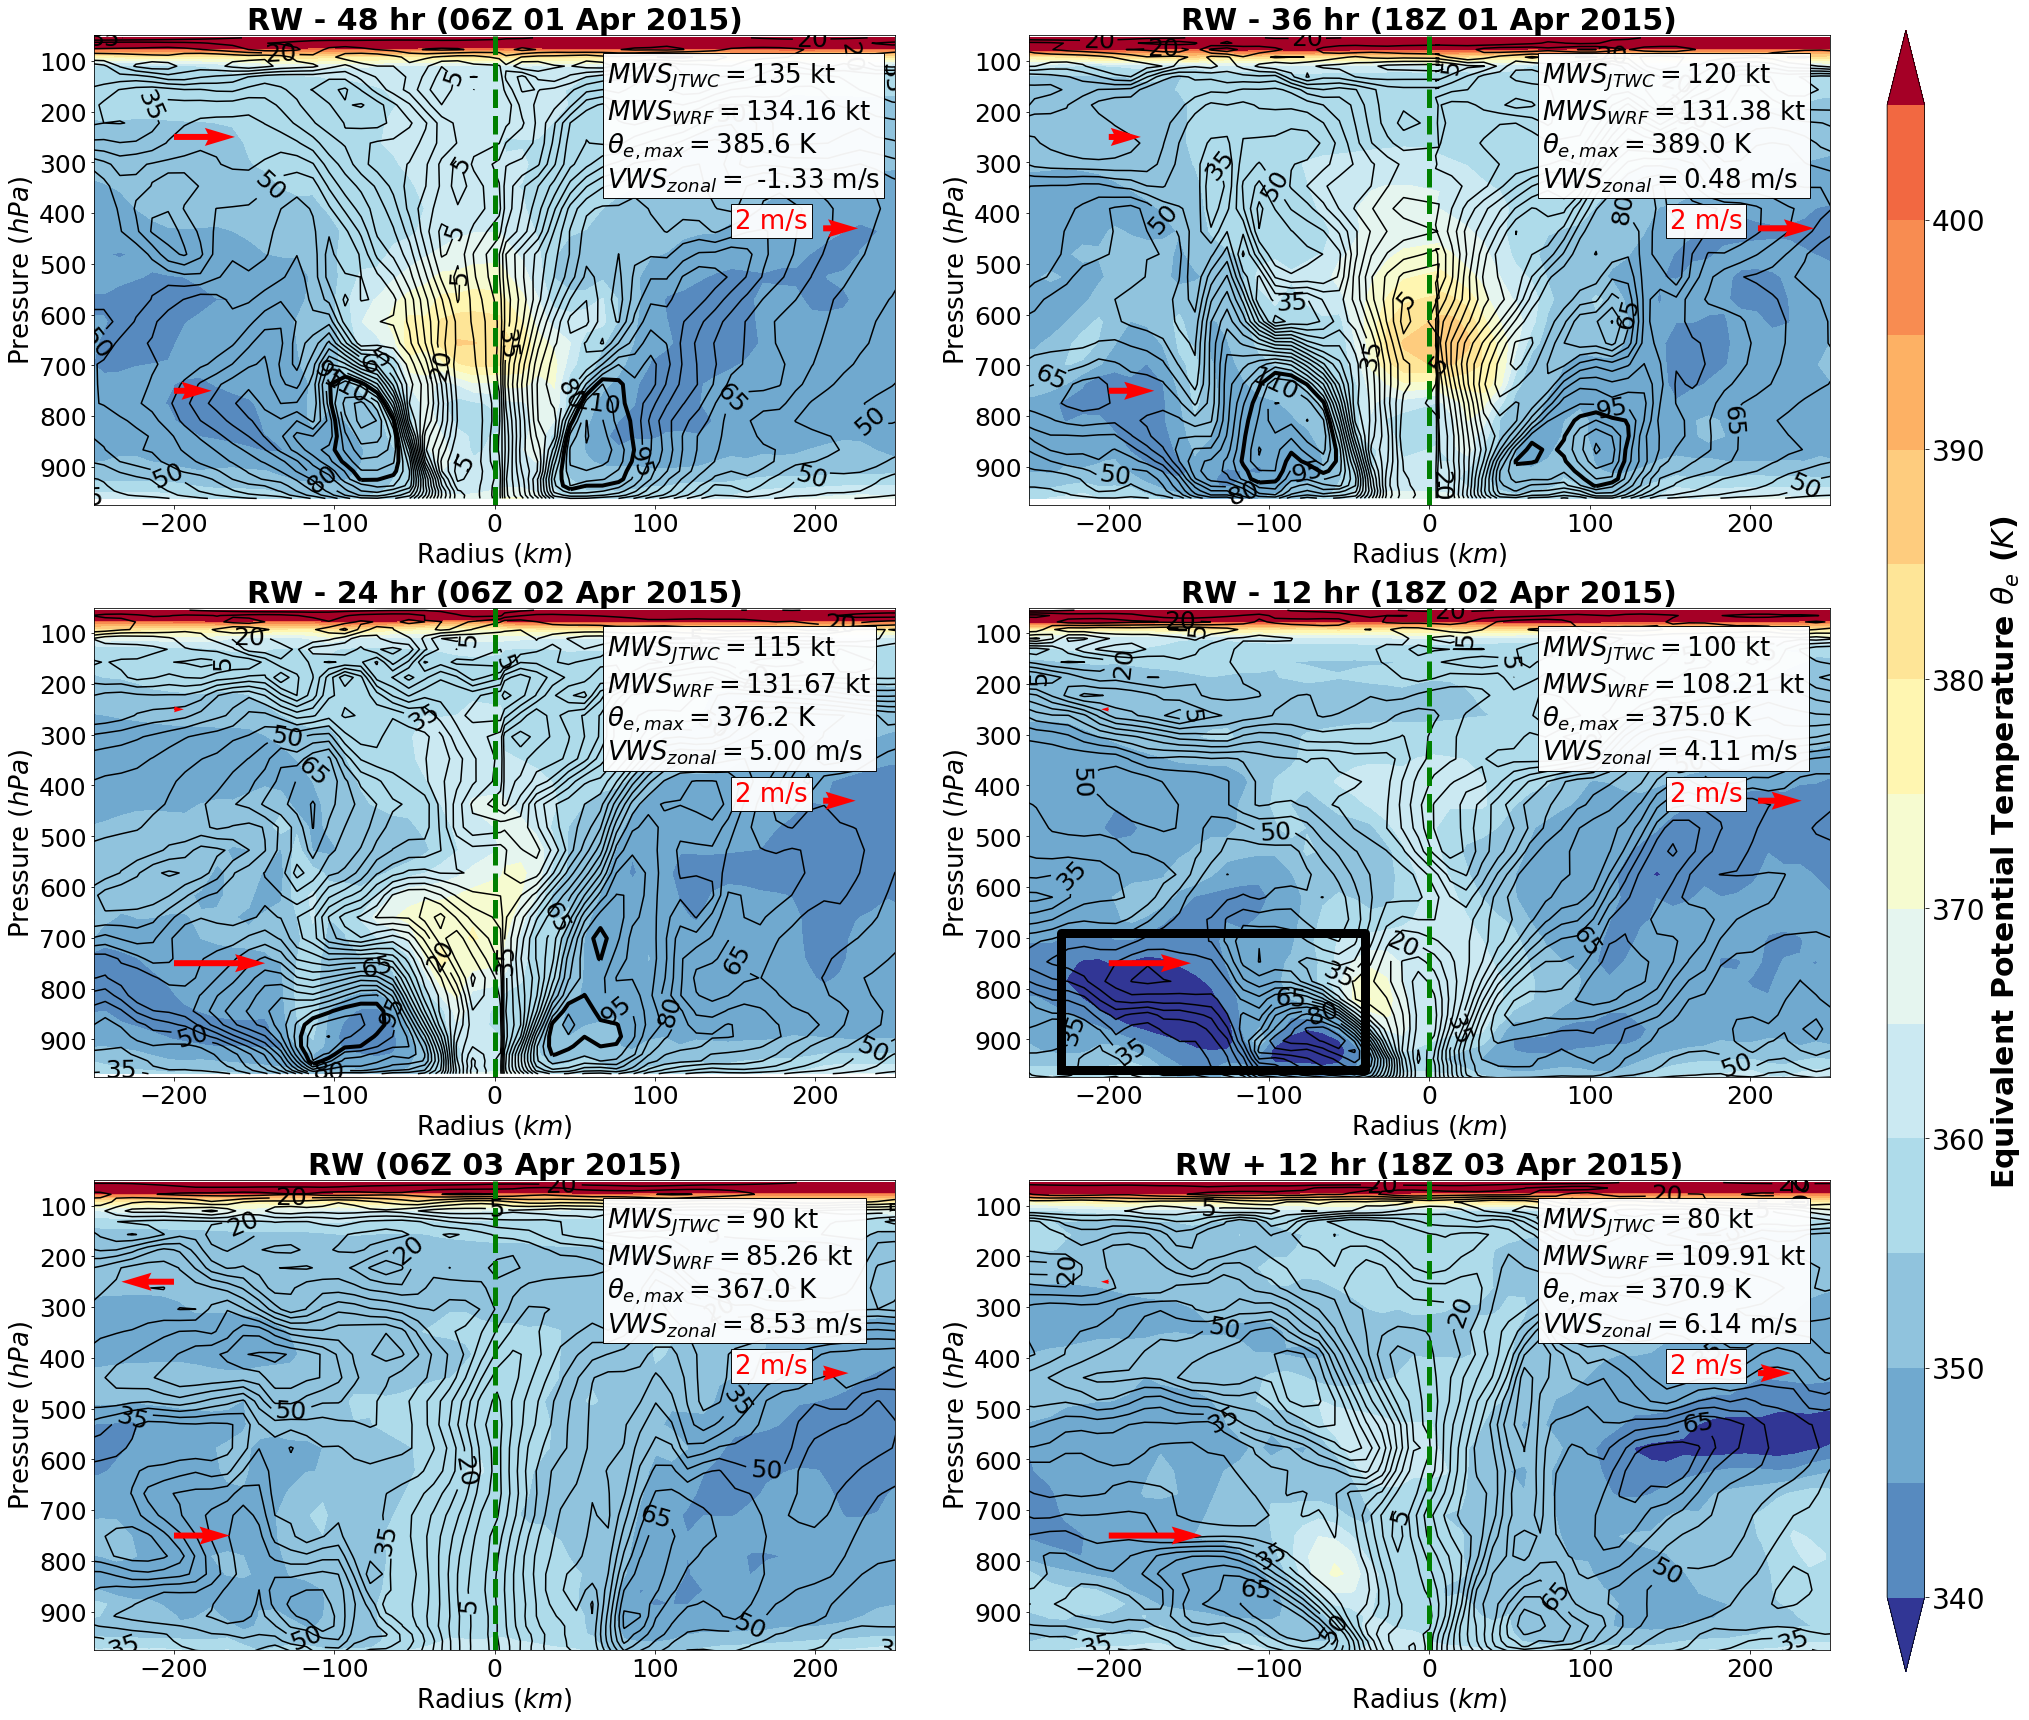

In [63]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (26,24))
#axes = (ax1, ax2, ax3, ax4)
cmap=cm.get_cmap('RdYlBu_r')

levels = np.arange(340, 410, 5)
levels1 = np.arange(0,150, 5)
axes[0, 0].set_title("RW - 48 hr (06Z 01 Apr 2015)", fontsize = 30,  fontweight = "bold")
c1 = axes[0,0].contour(dist1, press1, w1,levels1, colors = "k")
cf = axes[0,0].contourf(dist1, press1, te1, levels, cmap = cmap, vmin = 330, vmax = 420, extend = "both")
cl1 = plt.clabel(c1, levels1[1::3], inline=1, inline_spacing = -1,  fmt='%1.0f', fontsize=25, rightside_up = True)
c1.collections[20].set_linewidth(4)
plt.setp(axes[0,0].get_xticklabels(), Fontsize = 25)
plt.setp(axes[0,0].get_yticklabels(), Fontsize = 25)
axes[0,0].set_xlabel("Radius ($km$)", fontsize =26)
axes[0,0].set_ylabel("Pressure ($hPa$)", fontsize =26)
axes[0,0].set_yticks(np.arange(0,1000,100))
axes[0,0].set_ylim([50,975])
axes[0,0].set_xlim([-250, 250])
axes[0,0].invert_yaxis()
axes[0,0].axvline(x=0, color = "g", linestyle = "--",  linewidth = 5)

z1_xpos=[-200, -200, 205]
z1_ypos=[250, 750, 430]
z1_xd = [3.489616, 2.1555128, 2 ]
z1_yd = [0,0, 0]
axes[0,0].quiver(z1_xpos, z1_ypos, z1_xd, z1_yd,color ="red", zorder=200)

tex1 = r"$MWS_{JTWC} = 135$ kt" "\n" r"$MWS_{WRF} = 134.16$ kt " "\n" r"$\theta_{e,max} = 385.6$ K " "\n" r"$VWS_{zonal} =$ -1.33 m/s"
t1 = axes[0,0].text(70, 350, tex1, fontsize = 26, zorder = 199)
t1.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "k"))

text1 = r"2 m/s"
tx1= axes[0,0].text(150, 430, text1, fontsize = 26, zorder = 199, color = "r")
tx1.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "k"))


axes[0,1].set_title("RW - 36 hr (18Z 01 Apr 2015)", fontsize = 30,  fontweight = "bold")
c2 = axes[0,1].contour(dist2, press2, w2, levels1, colors = "k")
cf = axes[0,1].contourf(dist2, press2, te2, levels,cmap = cmap, vmin = 330, vmax = 420, extend = "both")
plt.clabel(c2, levels1[1::3], inline=1, inline_spacing = -1,  fmt='%1.0f', fontsize=25, rightside_up = True)
c2.collections[20].set_linewidth(4)
plt.setp(axes[0,1].get_xticklabels(), Fontsize = 25)
plt.setp(axes[0,1].get_yticklabels(), Fontsize = 25)
axes[0,1].set_xlabel("Radius ($km$)", fontsize =26)
axes[0,1].set_ylabel("Pressure ($hPa$)", fontsize =26)
axes[0,1].set_yticks(np.arange(0,1000,100))
axes[0,1].set_ylim([50,975])
axes[0,1].set_xlim([-250, 250])
axes[0,1].invert_yaxis()
axes[0,1].axvline(x=0, color = "g", linestyle = "--",  linewidth = 5)

z1_xpos=[-200, -200, 205]
z1_ypos=[250, 750, 430]
z1_xd = [1.145459, 1.6247786, 2 ]
z1_yd = [0,0, 0]
axes[0,1].quiver(z1_xpos, z1_ypos, z1_xd, z1_yd, color ="red", zorder=200)

tex2 = r"$MWS_{JTWC} = 120$ kt" "\n" r"$MWS_{WRF} = 131.38$ kt " "\n" r"$\theta_{e,max} = 389.0$ K " "\n" r"$VWS_{zonal} = 0.48$ m/s"
t2 = axes[0,1].text(70, 350, tex2, fontsize = 26, zorder = 199)
t2.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "k"))

text1 = r"2 m/s"
tx1= axes[0,1].text(150, 430, text1, fontsize = 26, zorder = 199, color = "r")
tx1.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "k"))


axes[1,0].set_title("RW - 24 hr (06Z 02 Apr 2015)", fontsize = 30,  fontweight = "bold")
c3 = axes[1,0].contour(dist3, press3, w3, levels1, colors = "k")
cf = axes[1,0].contourf(dist3, press3, te3, levels,cmap = cmap, vmin = 330, vmax = 420, extend = "both")
plt.clabel(c3, levels1[1::3], inline=1, inline_spacing = 1,  fmt='%1.0f', fontsize=25, rightside_up = True)
c3.collections[20].set_linewidth(4)
plt.setp(axes[1,0].get_xticklabels(), Fontsize = 25)
plt.setp(axes[1,0].get_yticklabels(), Fontsize = 25)
axes[1,0].set_xlabel("Radius ($km$)", fontsize =26)
axes[1,0].set_ylabel("Pressure ($hPa$)", fontsize =26)
axes[1,0].set_yticks(np.arange(0,1000,100))
axes[1,0].set_ylim([50,975])
axes[1,0].set_xlim([-250, 250])
axes[1,0].invert_yaxis()
axes[1,0].axvline(x=0, color = "g", linestyle = "--",  linewidth = 5)

z1_xpos=[-200, -200, 205]
z1_ypos=[250, 750, 430]
z1_xd = [0.60828274, 5.609927, 2]
z1_yd = [0,0, 0]
axes[1,0].quiver(z1_xpos, z1_ypos, z1_xd, z1_yd, color ="red", zorder=200)

#axes[1,0].quiver(-200, 250, 0.60828274, 0)
#axes[1,0].quiver(-200, 750, 5.609927, 0)
tex3 = r"$MWS_{JTWC} = 115$ kt" "\n" r"$MWS_{WRF} = 131.67$ kt " "\n" r"$\theta_{e,max} = 376.2$ K " "\n" r"$VWS_{zonal} = 5.00$ m/s"
t3 = axes[1,0].text(70, 350, tex3, fontsize = 26, zorder = 199)
t3.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "k"))

text1 = r"2 m/s"
tx1= axes[1,0].text(150, 430, text1, fontsize = 26, zorder = 199, color = "r")
tx1.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "k"))

axes[1,1].set_title("RW - 12 hr (18Z 02 Apr 2015)", fontsize = 30,  fontweight = "bold")
c4 = axes[1,1].contour(dist4, press4, w4,levels1, colors = "k")
cf = axes[1,1].contourf(dist4, press4, te4, levels,cmap = cmap, vmin = 330, vmax = 420, extend = "both")
plt.clabel(c4, levels1[1::3], inline=1, inline_spacing = 1,  fmt='%1.0f', fontsize=25, rightside_up = True)
c4.collections[20].set_linewidth(4)
plt.setp(axes[1,1].get_xticklabels(), Fontsize = 25)
plt.setp(axes[1,1].get_yticklabels(), Fontsize = 25)
axes[1,1].set_xlabel("Radius ($km$)", fontsize =26)
axes[1,1].set_ylabel("Pressure ($hPa$)", fontsize =26)
axes[1,1].set_yticks(np.arange(0,1000,100))
axes[1,1].set_ylim([50,975])
axes[1,1].set_xlim([-250, 250])
axes[1,1].invert_yaxis()
axes[1,1].axvline(x=0, color = "g", linestyle = "--",  linewidth = 5)

s_x = [-230, -230, -40,-40, -230]
s_y = [960, 690, 690, 960, 960]

axes[1,1].plot(s_x, s_y, "k-", linewidth =9 )

z1_xpos=[-200, -200, 205]
z1_ypos=[250, 750, 430]
z1_xd = [ -0.348768384,  3.760681, 2]
z1_yd = [0,0, 0]
axes[1,1].quiver(z1_xpos, z1_ypos, z1_xd, z1_yd, color ="red", zorder=200)

#axes[1,1].quiver(-200, 250, -0.34876838, 0)
#axes[1,1].quiver(-200, 750, 3.760681, 0)
tex4 = r"$MWS_{JTWC} = 100$ kt" "\n" r"$MWS_{WRF} = 108.21$ kt " "\n" r"$\theta_{e,max} = 375.0$ K " "\n" r"$VWS_{zonal} = 4.11$ m/s"
t4 = axes[1,1].text(70, 350, tex4, fontsize = 26, zorder = 199)
t4.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "k"))

text1 = r"2 m/s"
tx1= axes[1,1].text(150, 430, text1, fontsize = 26, zorder = 199, color = "r")
tx1.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "k"))

axes[2,0].set_title("RW (06Z 03 Apr 2015)", fontsize = 30,  fontweight = "bold")
c3 = axes[2,0].contour(dist5, press5, w5, levels1, colors = "k")
cf = axes[2,0].contourf(dist5, press5, te5, levels,cmap = cmap, vmin = 330, vmax = 420, extend = "both")
plt.clabel(c3, levels1[1::3], inline=1, inline_spacing = 1,  fmt='%1.0f', fontsize=25, rightside_up = True)
c3.collections[20].set_linewidth(4)
plt.setp(axes[2,0].get_xticklabels(), Fontsize = 25)
plt.setp(axes[2,0].get_yticklabels(), Fontsize = 25)
axes[2,0].set_xlabel("Radius ($km$)", fontsize =26)
axes[2,0].set_ylabel("Pressure ($hPa$)", fontsize =26)
axes[2,0].set_yticks(np.arange(0,1000,100))
axes[2,0].set_ylim([50,975])
axes[2,0].set_xlim([-250, 250])
axes[2,0].invert_yaxis()
axes[2,0].axvline(x=0, color = "g", linestyle = "--",  linewidth = 5)

z1_xpos=[-200, -200, 205]
z1_ypos=[250, 750, 430]
z1_xd = [ -4.1451464,   4.3845196, 2]
z1_yd = [0,0, 0]
axes[2,0].quiver(z1_xpos, z1_ypos, z1_xd, z1_yd,color ="red", zorder=200) 

text1 = r"2 m/s"
tx1= axes[2,0].text(150, 430, text1, fontsize = 26, zorder = 199, color = "r")
tx1.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "k"))

#axes[2,0].quiver(-200, 250, -4.1451464, 0, scale = 0.1)
#axes[2,0].quiver(-200, 750, 4.3845196, 0)
tex5 = r"$MWS_{JTWC} = 90$ kt" "\n" r"$MWS_{WRF} = 85.26$ kt " "\n" r"$\theta_{e,max} = 367.0$ K " "\n" r"$VWS_{zonal} = 8.53$ m/s"
t5 = axes[2,0].text(70, 350, tex5, fontsize = 26, zorder = 199)
t5.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "k"))

axes[2,1].set_title("RW + 12 hr (18Z 03 Apr 2015)", fontsize = 30,  fontweight = "bold")
c4 = axes[2,1].contour(dist6, press6, w6,levels1, colors = "k")
cf = axes[2,1].contourf(dist6, press6, te6, levels,cmap = cmap, vmin = 330, vmax = 420, extend = "both")
plt.clabel(c4, levels1[1::3], inline=1, inline_spacing = 1,  fmt='%1.0f', fontsize=25, rightside_up = True)
c4.collections[20].set_linewidth(4)
plt.setp(axes[2,1].get_xticklabels(), Fontsize = 25)
plt.setp(axes[2,1].get_yticklabels(), Fontsize = 25)
axes[2,1].set_xlabel("Radius ($km$)", fontsize =26)
axes[2,1].set_ylabel("Pressure ($hPa$)", fontsize =26)
axes[2,1].set_yticks(np.arange(0,1000,100))
axes[2,1].set_ylim([50,975])
axes[2,1].set_xlim([-250, 250])
axes[2,1].invert_yaxis()
axes[2,1].axvline(x=0, color = "g", linestyle = "--", linewidth = 5)

z1_xpos=[-200, -200, 205]
z1_ypos=[250, 750, 430]
z1_xd = [ -0.47366375,   5.665944, 2]
z1_yd = [0,0,0]
axes[2,1].quiver(z1_xpos, z1_ypos, z1_xd, z1_yd,color ="red", zorder=200) 

text1 = r"2 m/s"
tx1= axes[2,1].text(150, 430, text1, fontsize = 26, zorder = 199, color = "r")
tx1.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "k"))

tex6 = r"$MWS_{JTWC} = 80$ kt" "\n" r"$MWS_{WRF} = 109.91$ kt " "\n" r"$\theta_{e,max} = 370.9$ K " "\n" r"$VWS_{zonal} = 6.14$ m/s"
t6 = axes[2,1].text(70, 350, tex6, fontsize = 26, zorder = 199)
t6.set_bbox(dict(facecolor = "w", alpha = 0.95, edgecolor = "k"))


fig.tight_layout()
cbar_ax = fig.add_axes([1.01, 0.03, 0.02, 0.95])
cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), cax = cbar_ax, pad = 0.03)
cbar.set_label("Equivalent Potential Temperature " r"$\theta_{e}$ ($K$)", fontsize = 30, fontweight = "bold")
cbar.ax.tick_params(labelsize = 28)
cbar.ax.yaxis.offsetText.set(size = 28)

#cbar2 = fig.colorbar(c4, ax = axes.ravel())


